<a href="https://colab.research.google.com/github/penelopetir/24SBIOL74.03PT/blob/main/Final_Project_Spiking_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, we'll install neuron in our current runtime as usual.

In [ ]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 12.9 MB/s eta 0:00:00


Run the code block below just once to get all the files from the repository into our colab session and compile the MOD mechanism files we'll be using

In [ ]:
repo_name = 'BIOL74-Final-Project'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/penelopetir/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name) # Changing working directory to downloaded repository

# Compile mechanisms
!nrnivmodl mechanisms

Cloning into 'BIOL74-Final-Project'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 399 (delta 133), reused 162 (delta 91), pack-reused 182
Receiving objects: 100% (399/399), 1.28 MiB | 4.41 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/BIOL74-Final-Project/BIOL74-Final-Project
Mod files: "mechanisms/mechanisms/CadepK.mod" "mechanisms/mechanisms/Ca.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mechanisms/CadepK.mod
 -> NMODL ../mechanisms/Ca.mod
Translating Ca.mod into /content/BIOL74-Final-Project/BIOL74-Final-Project/x86_64/Ca.c
Translating CadepK.mod into /content/BIOL74-Final-Project/BIOL74-Final-Project/x86_64/CadepK.c
Thread Safe
Thread Safe
 -> Compiling Ca.c
 -> Compiling CadepK.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/specia

## Introduction
For this exercise, we'll be adapting a model of a L5PC to model granule neurons traced from wild type and PTEN KO groups


Start by importing the packages we'll be using.

In [ ]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if 'google.colab' in str(get_ipython()): # For making interactive plots work on google colab
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    plotly.offline.init_notebook_mode() # for printing notebooks offline

## FI Curve Generation

It is time to add the channels back into the soma. According to the aradi et al. model, there are calcium, sodium and potassium channels that are in the soma. For simplicity's sake, we will only add back in the sodium and potassium channels.

In [ ]:
from helper_functions import createGranuleCell

#instantiate with active properties
genotype = "WT"
if genotype == "WT":
  WT_file = "morphologies/WT.asc" # morphology file
  GC = createGranuleCell(WT_file, "active")
elif genotype == "KO":
  KO_file = "morphologies/PTEN_KO.asc" # morphology file
  GC = createGranuleCell(KO_file, "active")
else:
  print("No neuron found")

# Create recording vectors for time and somatic voltage
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(GC.soma[0](0.5)._ref_v)

In [ ]:
h.psection()

granuletemplate[2].soma[0] { nseg=1  L=9.35859  Ra=210
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=4.86001}
	insert capacitance { cm=1}
	insert pas { g_pas=2.5e-05 e_pas=-70}
	insert extracellular { xraxial=1e+09 xg=1e+09 xc=0 e_extracellular=0}
	insert Ca { gtcabar_Ca=0.0018 gncabar_Ca=0 glcabar_Ca=0}
	insert CadepK { gbkbar_CadepK=0 gskbar_CadepK=0}
	insert ca_ion {}
	insert Na { gmax_Na=0.12}
	insert na_ion { ena=45}
	insert fKDR { gmax_fKDR=0.016}
	insert sKDR { gmax_sKDR=0.003}
	insert k_ion { ek=-85}
}


1.0

In [ ]:
#creating an object to store our spike times using the NetCon object
netcon = h.NetCon(GC.soma[0](0.5)._ref_v,None) # Use NetCon to monitor axon voltage
netcon.threshold = 0 # set threshold to detect AP
# Record spike times
spike_times = h.Vector()
netcon.record(spike_times) # pass the spiketimes vector to the record method of the netcon object we just created

0.0

In [ ]:
#creating current clamp
iclamp = h.IClamp(GC.soma[0](0.5))

#generating a recording vector for current
Ic = h.Vector().record(iclamp._ref_i)

In [ ]:
#helper function to find the index of the occurence of a value (num) in an array
def find_index(num, vector):
  diff = [np.abs(element - num) for element in np.array(vector)]
  return np.argmin(diff)

def run_and_plot_Iclamp_sim(t,v,ic):
    h.run()
    # Plot results
    fig = make_subplots(rows=2,cols=1)
    # voltage
    fig.add_trace(go.Scatter(x=t,y=v,showlegend=False),row=1,col=1)
    fig['layout']['yaxis']['title']='Vm (mV)'
    # Current
    fig.add_trace(go.Scatter(x=t,y=ic,showlegend=False),row=2,col=1)
    fig['layout']['xaxis2']['title']='time (ms)'
    fig['layout']['yaxis2']['title']='Ic (nA)'
    fig.show()

In [ ]:
#current clamp settings
if genotype == "WT":
  iclamp.amp = 0.16 #nA
else: #KO
  iclamp.amp = 0.8 #nA
iclamp.dur = 500 #ms
iclamp.delay = 5 #ms

#simulation settings
h.v_init = -70 # mV - initial voltage of the model system
h.dt = 0.1  # ms - time step
h.celsius = 37 # degrees celsius - ephys recordings at this temp
h.tstop = 600 # ms - simulation duration

# Run
run_and_plot_Iclamp_sim(t_vec, v_soma, Ic)
print(f"Number of Spikes: {len(spike_times)}")

Changed dt


Number of Spikes: 41


In [ ]:
# Figure creation
fig = plt.figure()
amp_vec = np.arange(0,2,0.1)
F_vec = []
for amp in amp_vec:
    iclamp.amp = amp # nA
    # Run
    h.run()
    Fi = len(spike_times)/0.5 # number of spikes divided by length of simulation in sec
    F_vec.append(Fi)

<Figure size 640x480 with 0 Axes>

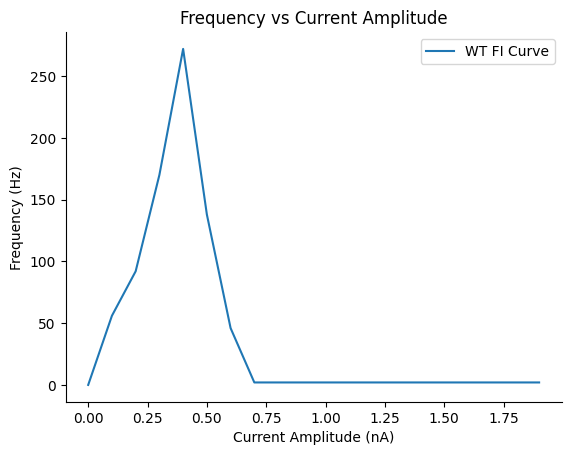

In [ ]:
plt.plot(amp_vec,F_vec, label = f"{genotype} FI Curve")
plt.title("Frequency vs Current Amplitude")
plt.xlabel("Current Amplitude (nA)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.show()

In [ ]:
print(np.max(F_vec))

272.0
